<p><font size="6" color='grey'> <b>
Machine Learning
</b></font> </br></p>
<p><font size="5" color='grey'> <b>
Simple RAG für Dateien
</b></font> </br></p>

---


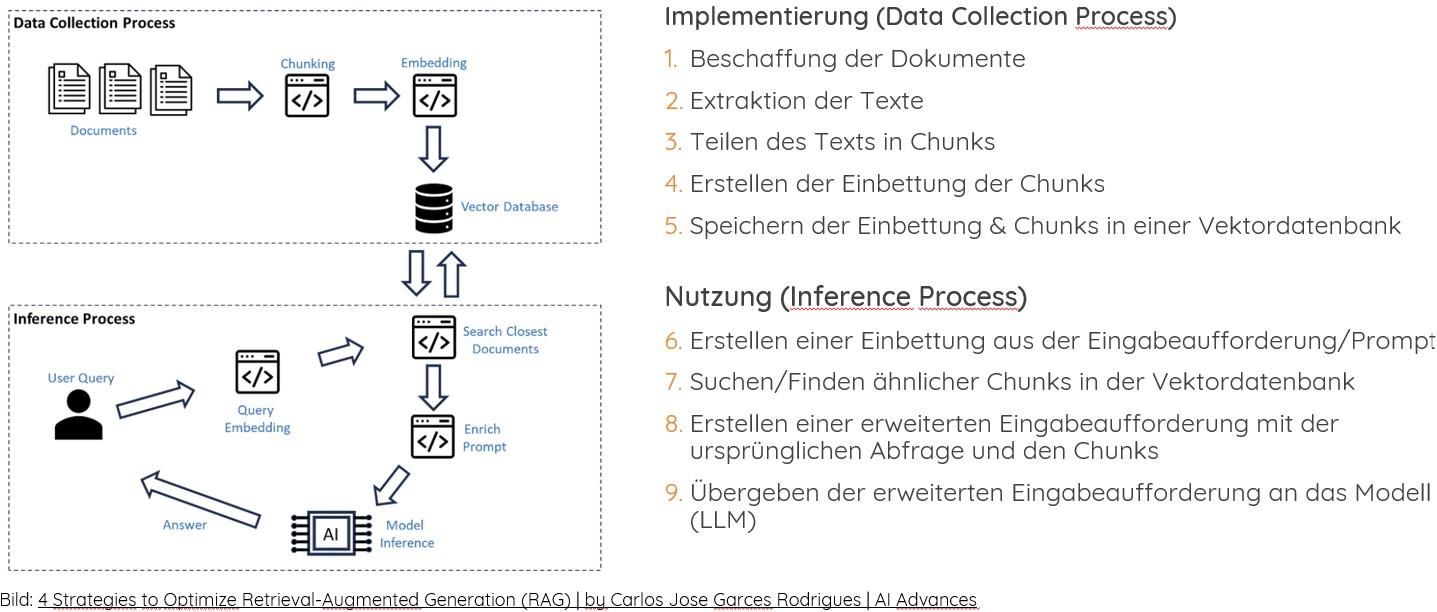

**Aufgabenbeschreibung:**

Der Code demonstriert die Erstellung eines einfachen RAG-basierten Chatbots. Die Hauptaufgaben bestehen darin, Dokumente zu laden, Embeddings zu erstellen, eine Vektordatenbank aufzubauen, eine Retrieval Chain zu definieren und die Interaktion mit dem Sprachmodell zu verwalten. Der Chatbot ist in der Lage, Fragen zu den Inhalten der Dokumente zu beantworten und gibt die relevanten Quellen an.

# **1 | Setup und Installation**
---



## **1.1 Erstellen der requirements.txt**

In [ ]:
%%writefile requirements.txt
langchain-community>=0.0.16
langchain-openai>=0.0.5
langchain-chroma>=0.0.13
tiktoken>=0.5.2
pypdf>=3.9.0
unstructured[all-docs]>=0.11.2
gradio>=3.50.0
openai==1.55.3
httpx==0.27.2
anyio==3.7.1

## **1.2 Installation der Bibliotheken**

In [ ]:
# Installation der requirements
!uv pip install -q -U --system -r requirements.txt

In [ ]:
# Hilfslösung für Fehler mit OpenAI 1.56.0
# !pip install openai==1.55.3 httpx==0.27.2 --force-reinstall --quiet
# import os
# os.kill(os.getpid(), 9)

## **1.3 Import der Module**

In [ ]:
# Standardbibliotheken
import os
import re
import warnings

# Drittanbieterbibliotheken
import gradio as gr
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.document_loaders import DirectoryLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma

# Warnungen ausschalten
warnings.filterwarnings('ignore')

# **2 | Konfiguration und Umgebungsvariablen**
---



## **2.1 API-Schlüssel und Zugangsdaten**

In [ ]:
# OpenAI API-Schlüssel setzen
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OpenAI-API-Key')

## **2.2 Modellparameter und globale Variablen**

In [ ]:
# Verzeichnisse
DIRECTORY_PATH = "/content/Dateien"
PERSIST_DIRECTORY = "/content/Vektordatenbank"

# Loader-Konfiguration
LOADER_MAPPING = {
    "*.md": UnstructuredMarkdownLoader,
    "*.docx": UnstructuredWordDocumentLoader,
    "*.pdf": PyPDFLoader,
}

# Chat-Verlauf initialisieren
chat_history = []

# **3 | Datenvorverarbeitung und Embedding**
---



## **3.1 Datenextraktion**

In [ ]:
# Kopieren der Dateien von Github
!mkdir Dateien
!curl -L https://raw.githubusercontent.com/ralf-42/ML_Intro/main/02%20data/_rag/_files/Der-Weihnachtsabend.pdf -o Dateien/Der-Weihnachtsabend.pdf
!curl -L https://raw.githubusercontent.com/ralf-42/ML_Intro/main/02%20data/_rag/_files/In-den-tiefen-Waeldern.docx -o Dateien/In-den-tiefen-Waeldern.docx
!curl -L https://raw.githubusercontent.com/ralf-42/ML_Intro/main/02%20data/_rag/_files/Git-Grundbegriffe.md -o Dateien/Git-Grundbegriffe.md

# Funktion zum Laden der Dokumente
def load_documents_from_directory(directory_path):
    """Lädt Dokumente aus dem angegebenen Verzeichnis basierend auf den unterstützten Dateitypen."""
    documents = []
    for file_pattern, loader_cls in LOADER_MAPPING.items():
        loader = DirectoryLoader(directory_path, glob=file_pattern, loader_cls=loader_cls)
        documents.extend(loader.load())
    return documents

# Dokumente laden
documents = load_documents_from_directory(DIRECTORY_PATH)

## **3.2 Text Splitting**

In [ ]:
# Text-Splitter konfigurieren und Dokumente aufteilen
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
docs = text_splitter.split_documents(documents)

## **3.3 Embeddings erstellen**

In [ ]:
# Embeddingsmodell festlegen
embeddings = OpenAIEmbeddings()

## **3.4 Vektordatenbank aufbauen**

In [ ]:
# Vektordatenbank erstellen und speichern
vectorstore = Chroma.from_documents(docs, embeddings, persist_directory=PERSIST_DIRECTORY)

# **4 | Memory und Kontextmanagement**
---



## **4.1 Konversationsgedächtnis einrichten**

In [ ]:
# Bereits im globalen chat_history implementiert

## **4.2 Kontextinformation aus Datenbank**


*nicht relevant für diesen einfachen Chatbot*



# **5 | Prompt-Engineering**
---



## **5.1 Systemprompt definieren**

In [ ]:
# Template/Vorlage der Eingaben
prompt = ChatPromptTemplate.from_template(
    """Beantworten Sie die folgende Frage ausschließlich auf der Grundlage des bereitgestellten Kontexts, antworte in deutscher Sprache:

<context>
{context}
</context>

Question: {input}"""
)

## **5.2 Dynamische Prompt-Templates**


*nicht relevant für diesen einfachen Chatbot*



# **6 | RAG-Chatbot-Architektur**
---



## **6.1 Retrieval Chain aufbauen**

In [ ]:
# Festlegen LLM und Retriever
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
retriever = vectorstore.as_retriever()

# Kette für Dokumentenverarbeitung
document_chain = create_stuff_documents_chain(llm, prompt)

# Retrieval-Kette erstellen
retrieval_chain = create_retrieval_chain(retriever, document_chain)

## **6.2 Chat-Logik implementieren**

In [ ]:
def chat_openai(message, chat_history=[]):
    """Verarbeitet die Chatanfrage und gibt eine formatierte Antwort mit Quellenangaben zurück."""
    # Frage an die Retrieval-Kette senden
    result = retrieval_chain.invoke({"input": message})
    answer = result["answer"]
    source_docs = result.get("source_documents", [])

    # Quellen extrahieren (Dateinamen) wenn gefunden
    content_not_found = r"\bnot provide\b|\bnot found\b|\bnot contain\b|\bkeine Informationen\b|\bno answer\b|\bnot a valid question\b"
    not_found = re.findall(content_not_found, answer)
    if not_found != []:
        sources_text = "keine Quellen"
    else:
        sources = [os.path.basename(doc.metadata['source']) for doc in result['context']]
        sources = set(sources)
        sources_text = "\n".join(f"- {source}" for source in sources)

    # Antwort mit Quellenangaben formatieren
    full_response = f"{answer}\n\n**Quellen:**\n{sources_text}"

    return full_response

# **7 | Interaktions- und Testfunktionen**
---



## **7.1 Gradio Interface erstellen**

In [ ]:
demo = gr.ChatInterface(
    fn=chat_openai,
    type="messages",
    title="📚 Dokumentenbasierter Chatbot mit Quellenangabe",
    description="\n\n*Der Chatbot wertet die verfügbaren Dokumente aus und beantwortet Fragen zum Inhalt*"
)

## **7.2 App starten**

In [ ]:
demo.launch()